#### Coded and Written by Simon Varadaraj
# Credit Card Fraud Detection

### Information about the Dataset
Data was gathered from Kaggle and can be viewed with the provided [hyperlink](https://www.kaggle.com/datasets/kartik2112/fraud-detection). The dataset contains legitimate and fraudulent credit card transactions from the duration "1st Jan 2019 - 31st Dec 2020". Data was generated using [Sparkov Data Generation](https://github.com/namebrandon/Sparkov_Data_Generation) created by Brandon Harris. 

## The Goal of the Project
- **Find the most impactful features** of a credit card transaction that can be used to predict if any interaction is fraudulent
- **Visualize** important aspects of the data, in a way that make intuitive sense for a user without field experience
- Provide Methods for which to use the model to **prevent fraudulent transactions** before they happen

### Importing the Libraries

In [1]:
# Standard libaries
import pandas as pd
import numpy as np

# Model that will be used is Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# To check most impactful features
from sklearn.inspection import permutation_importance

# Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### Acquiring the Data

In [2]:
dataTrain = pd.read_csv('files/fraudTrain.csv', parse_dates=True, index_col=0)
dataTest = pd.read_csv('files/fraudTest.csv', parse_dates=True, index_col=0)

### Further Insights into the Dataset

In [3]:
dataTrain.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
dataTrain.shape

(1296675, 22)

In [5]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [6]:
# Out of the 22 Columns, only 10 are numerical. This means that many of the features need to be encoded
len(dataTrain.select_dtypes(include='number').columns)

10

### Deleting Intuitively Useless Features

#### The Deleted Features are:
- **cc_num**: this variable is entirely random and does not affect the transaction model
- **trans_num**: this variable is entirely random and does not affect the transaction
- **unix_time**: time variable is already provided, so this is redundant
- **first** and **last**: the name of the cardholder holds no significant value to the model
- **street**, **city**: each value is too unqiue, and thus cannot be used in a broad ML model as such
- **job**: source of income should not really determine the kinds of transactions a user does

In [7]:
dataTrain = dataTrain.drop(['cc_num', 'unix_time', 'trans_num', 'first', 'last', 'street', 'city', 'job'], axis='columns')

In [8]:
dataTest = dataTest.drop(['cc_num', 'unix_time', 'trans_num', 'first', 'last', 'street', 'city', 'job'], axis='columns')

## Dealing with Categorical Data

The article in the hyperlink [here](https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html) shows a great amount of insight about how to deal with categorical data for ML models, especially when using the sklearn module.

In [9]:
# This shows what columns are needing to be accounted for, 
# and thus needs conversion

dataTrain.select_dtypes(include='object').head()

,trans_date_trans_time,merchant,category,gender,state,dob
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,F,NC,1988-03-09
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,F,WA,1978-06-21
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,M,ID,1962-01-19
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,M,MT,1967-01-12
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,M,VA,1986-03-28


### Simpler Categories to Deal With

Some of the categorical data columns will be easier to coax into numerical values.

#### This includes:
- **dob**: date of birth --> datetime
- **trans_date_trans_time**: date of birth --> datetime
- **gender**: 0/1 --> integer

In [10]:
# Converting the datetime columns
dataTrain['dob'] = pd.to_datetime(dataTrain['dob'])
dataTrain['trans_date_trans_time'] = pd.to_datetime(dataTrain['trans_date_trans_time'])

dataTest['dob'] = pd.to_datetime(dataTest['dob'])
dataTest['trans_date_trans_time'] = pd.to_datetime(dataTest['trans_date_trans_time'])

In [11]:
gendermap = {'M': 0, 'F': 1}
dataTrain['gender'] = dataTrain['gender'].apply(lambda x: gendermap[x])
dataTest['gender'] = dataTest['gender'].apply(lambda x: gendermap[x])

### More Difficult Categories to Deal With

These columns will need to be divided into distinct categories, and then mapped into numerical values in order to be used in the Machine Learning Model.

#### This includes:
- ~~**merchant**: users need to be grouped by merchants~~
- **category**: numerocal columns can be derived from the one hot encoder method
- **state**: location of the state can be used as a category

### Insights about the Categorized Data
None of the categories have a particular order, and this can be classified as Nominal Data. Nominal data can be encoded via One-hot Encoding

### Categorizing the Merchants

In [12]:
# There are 693 possible merchants, with no obvious way to group them
# this property makes this feature UNFEASABLE
len(dataTrain['merchant'].value_counts())

693

In [13]:
dataTrain = dataTrain.drop('merchant', axis='columns')
dataTest = dataTest.drop('merchant', axis='columns')

In [14]:
# 14 possible categories makes each category more significant in determining fraud
dataTrain['category'].value_counts()

gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: category, dtype: int64

### Categorizing the Category of Transaction

In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

ohe_category_train = ohe.fit_transform(dataTrain[['category']])
ohe_category_test = ohe.fit_transform(dataTest[['category']])

cat_table_train = pd.DataFrame(ohe_category_train)
cat_table_test = pd.DataFrame(ohe_category_test)

### What Each Column Maps to
- 0 : entertainment
- 1 : food_dining
- 2 : gas_transport
- 3 : grocery_net
- 4 : grocery_pos
- 5 : health_fitness
- 6 : home
- 7 : kids_pets
- 8 : misc_net
- 9 : misc_pos
- 10 : personal_care
- 11 : shopping_net
- 12 : shopping_pos
- 13 : travel

In [16]:
columns = pd.Series(['is_entertainment' , 'is_food_dining' , 
                    'is_gas_transport', 'is_grocery_net', 'is_grocery_pos', 
                    'is_health_fitness', 'is_home', 'is_kids_pets', 
                    'is_misc_net', 'is_misc_pos', 'is_personal_care', 
                    'is_shopping_net', 'is_shopping_pos', 'is_travel'])

cat_table_train.columns = columns
cat_table_test.columns = columns

for col in columns:
    dataTrain[col] = cat_table_train[col]
    dataTest[col] = cat_table_test[col]

In [17]:
dataTrain = dataTrain.drop('category', axis='columns')
dataTest = dataTest.drop('category', axis='columns')

### Categorizing the States

In [18]:
# Map created with chatGPT, used to create broader categories

us_state_regions = {
    'AL': 'South',
    'AK': 'West',
    'AZ': 'West',
    'AR': 'South',
    'CA': 'West',
    'CO': 'West',
    'CT': 'Northeast',
    'DE': 'South',
    'FL': 'South',
    'GA': 'South',
    'HI': 'West',
    'ID': 'West',
    'IL': 'Midwest',
    'IN': 'Midwest',
    'IA': 'Midwest',
    'KS': 'Midwest',
    'KY': 'South',
    'LA': 'South',
    'ME': 'Northeast',
    'MD': 'South',
    'MA': 'Northeast',
    'MI': 'Midwest',
    'MN': 'Midwest',
    'MS': 'South',
    'MO': 'Midwest',
    'MT': 'West',
    'NE': 'Midwest',
    'NV': 'West',
    'NH': 'Northeast',
    'NJ': 'Northeast',
    'NM': 'West',
    'NY': 'Northeast',
    'NC': 'South',
    'ND': 'Midwest',
    'OH': 'Midwest',
    'OK': 'South',
    'OR': 'West',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'SC': 'South',
    'SD': 'Midwest',
    'TN': 'South',
    'TX': 'South',
    'UT': 'West',
    'VT': 'Northeast',
    'VA': 'South',
    'WA': 'West',
    'WV': 'South',
    'WI': 'Midwest',
    'WY': 'West',
    'DC': 'Northeast'
}

In [19]:
dataTrain_regions = dataTrain['state'].apply(lambda x: us_state_regions[x])
dataTest_regions = dataTest['state'].apply(lambda x: us_state_regions[x])

In [20]:
ohe_region_train = ohe.fit_transform(pd.DataFrame(dataTrain_regions))
ohe_region_test = ohe.fit_transform(pd.DataFrame(dataTest_regions))

region_train_table = pd.DataFrame(ohe_region_train)
region_test_table = pd.DataFrame(ohe_region_test)

### What Each Column Maps to
- 0 : Midwest
- 1 : Northeast
- 2 : South
- 3 : West

In [21]:
reg_columns = pd.Series(['is_midwest', 'is_northeast', 'is_south', 'is_west'])

region_train_table.columns = reg_columns
region_test_table.columns = reg_columns

for col in reg_columns:
    dataTrain[col] = region_train_table[col]
    dataTest[col] = region_test_table[col]

In [22]:
dataTrain = dataTrain.drop(['state'], axis='columns')
dataTest = dataTest.drop(['state'], axis='columns')

### Making Sure all Columns are Numerical

In [23]:
dataTest.select_dtypes(include='object').shape

(555719, 0)

In [24]:
dataTrain.select_dtypes(include='object').shape

(1296675, 0)

## After Removing Categorical Values

### Deleting Useless Numerical Values
#### The Deleted Features are:
- **zip**: location is already given via region features
- **lat** and **long**: location is already given via region features, however these values may be useful in creating new column values to track distance
- **city_pop**: no reason for population to interfere with credit card transactiions

In [25]:
dataTrain['lat_dist'] = abs(dataTrain['lat'] - dataTrain['merch_lat'])
dataTest['lat_dist'] = abs(dataTest['lat'] - dataTest['merch_lat'])

dataTrain['long_dist'] = abs(dataTrain['long'] - dataTrain['merch_long'])
dataTest['long_dist'] = abs(dataTest['long'] - dataTest['merch_long'])

In [26]:
dataTrain = dataTrain.drop(['lat', 'long'], axis='columns')
dataTest = dataTest.drop(['lat', 'long'], axis='columns')

In [27]:
dataTrain = dataTrain.drop(['city_pop', 'zip'], axis='columns')
dataTest = dataTest.drop(['city_pop', 'zip'], axis='columns')

In [28]:
old_train = dataTrain['trans_date_trans_time'] - dataTrain['dob']
old_test = dataTest['trans_date_trans_time'] - dataTest['dob']

In [29]:
dataTrain['age'] = old_train.apply(lambda x: x.days / 365)
dataTest['age'] = old_test.apply(lambda x: x.days / 365)

In [30]:
dataTrain = dataTrain.drop(['trans_date_trans_time', 'dob'], axis='columns')
dataTest = dataTest.drop(['trans_date_trans_time', 'dob'], axis='columns')

### Data Cleansing has been Completed

## Feature Selection

In [31]:
dataTrain.corr().style.background_gradient(cmap='Blues')

,amt,gender,merch_lat,merch_long,is_fraud,is_entertainment,is_food_dining,is_gas_transport,is_grocery_net,is_grocery_pos,is_health_fitness,is_home,is_kids_pets,is_misc_net,is_misc_pos,is_personal_care,is_shopping_net,is_shopping_pos,is_travel,is_midwest,is_northeast,is_south,is_west,lat_dist,long_dist,age
amt,1.000000,-0.001034,-0.001873,-0.000151,0.219404,-0.010709,-0.033102,-0.014503,-0.019831,0.094389,-0.026860,-0.024408,-0.024701,0.014856,-0.011905,-0.038303,0.032153,0.018492,0.046097,-0.003684,0.001513,0.000357,0.002494,-0.000788,-0.000450,-0.009752
gender,-0.001034,1.000000,-0.042645,-0.050350,-0.007642,-0.019591,-0.010173,0.003029,0.003297,-0.011994,-0.011030,-0.011206,0.005471,0.007138,-0.007930,0.033654,0.011368,0.021437,-0.018289,-0.015949,-0.025389,0.022334,0.017804,-0.001522,0.001129,-0.006087
merch_lat,-0.001873,-0.042645,1.000000,-0.015431,0.001741,0.002570,-0.002208,0.017382,-0.012491,-0.000609,0.004837,-0.002501,-0.001046,0.003603,-0.003271,-0.002543,-0.001126,-0.009187,0.003069,0.399016,0.306308,-0.715559,0.132665,0.000042,0.000382,0.047600
merch_long,-0.000151,-0.050350,-0.015431,1.000000,0.001721,-0.000586,0.004486,-0.002648,0.003110,0.000468,-0.002649,0.000130,-0.000272,-0.003679,0.006268,-0.001994,-0.004573,0.000906,0.003072,-0.023277,0.528021,0.166264,-0.782076,0.001119,0.001179,-0.029786
is_fraud,0.219404,-0.007642,0.001741,0.001721,1.000000,-0.012200,-0.015025,-0.004851,-0.007136,0.035558,-0.014885,-0.017848,-0.014967,0.025886,-0.008937,-0.012167,0.044261,0.005955,-0.006924,0.000242,0.001604,-0.001368,-0.000216,0.000655,-0.000201,0.012270
is_entertainment,-0.010709,-0.019591,0.002570,-0.000586,-0.012200,1.000000,-0.077021,-0.093991,-0.053289,-0.090771,-0.074462,-0.090558,-0.086402,-0.063333,-0.071529,-0.076702,-0.079742,-0.087916,-0.050207,0.003430,0.000228,-0.003086,-0.000378,-0.001179,-0.000790,0.001084
is_food_dining,-0.033102,-0.010173,-0.002208,0.004486,-0.015025,-0.077021,1.000000,-0.092607,-0.052504,-0.089435,-0.073366,-0.089225,-0.085130,-0.062401,-0.070476,-0.075574,-0.078569,-0.086622,-0.049468,-0.000774,0.001705,0.001104,-0.002415,-0.001232,-0.000242,-0.018712
is_gas_transport,-0.014503,0.003029,0.017382,-0.002648,-0.004851,-0.093991,-0.092607,1.000000,-0.064072,-0.109139,-0.089530,-0.108884,-0.103886,-0.076149,-0.086004,-0.092224,-0.095879,-0.105706,-0.060367,0.014497,0.000783,-0.010607,-0.004719,0.001290,0.000202,0.038680
is_grocery_net,-0.019831,0.003297,-0.012491,0.003110,-0.007136,-0.053289,-0.052504,-0.064072,1.000000,-0.061877,-0.050759,-0.061732,-0.058899,-0.043173,-0.048760,-0.052287,-0.054359,-0.059931,-0.034226,-0.006695,-0.004240,0.008315,0.001814,0.000669,-0.000195,-0.078822
is_grocery_pos,0.094389,-0.011994,-0.000609,0.000468,0.035558,-0.090771,-0.089435,-0.109139,-0.061877,1.000000,-0.086463,-0.105153,-0.100327,-0.073541,-0.083057,-0.089064,-0.092594,-0.102085,-0.058299,-0.001691,0.001043,0.000028,0.000945,0.000284,0.000350,0.018162


### What the Figure Above Shows

The figure shows that **none of the features** are correlated to each other **above the threshold of .8**, this means that all of the features seem to be independant of each other. This implies that **every feature** in the DataFrame has different effects on the model.

## What Model is Best Suited for the Task?

The [scikit](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) website provides a flowchart to pick out the optimal model for any specific use case. In this particular case, I wish to pick out a category and will be employing supervised learning. I have over 100k samples, and thus am supposed to use a **Stochastic Gradient Descent** model, as shown in the imports at the very beginning.
### Modeling

In [32]:
# Dividing the independent and response variables
X_train = dataTrain.drop('is_fraud', axis='columns')
X_test = dataTest.drop('is_fraud', axis='columns')
y_train = dataTrain['is_fraud']
y_test = dataTest['is_fraud']

In [33]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.9777603429071168

### Overfitting

The very high accuracy score definitely shows signs that the model has been overfit, even after adjusting the the hyperparameters for the Classifier model. This means that the data once again needs to be checked. First, let's check for a balanced target set.

<AxesSubplot:ylabel='is_fraud'>

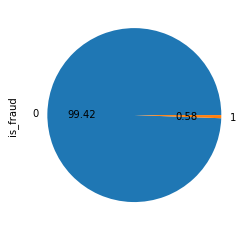

In [34]:
y_train.value_counts().plot.pie(autopct='%.2f')

In [35]:
y_test.value_counts() / len(y_test)

0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

As you can see, the dataset is highly unbalanced, which was unchecked before. This can be fixed via *Random Oversampling*. Such as large change in distribution however will create a massive impact on the dataset.

<AxesSubplot:ylabel='is_fraud'>

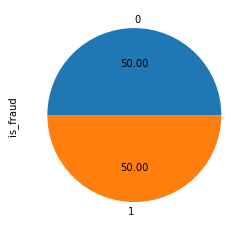

In [36]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy='not majority')
X_res, y_res = ros.fit_resample(X_train, y_train)

# This plot shows the change in distribution for the y-train set
y_res.value_counts().plot.pie(autopct='%.2f')

In [37]:
# Using the new unbalanced data
sgd.fit(X_res, y_res)
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.8324980790651391

### Effects of Random Oversampling

It seems to have made a *positive impact*, as the accuracy score is not as dangerously high, and is far greater than the ratio of non-fraudulent to fraudulent purchases, unlike in the previous model. 

### Finding the Most Significant Features

In [38]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(sgd, X_test, y_test)
perm.importances_mean

array([ 8.55576289e-03,  8.27756474e-05,  7.42101674e-04, -1.23083789e-04,
        3.55935284e-03,  2.31498293e-02,  2.87677765e-02,  1.46505698e-02,
        6.17398361e-03,  2.08493861e-02,  2.21021775e-02,  2.62949440e-02,
       -3.53056131e-04,  2.74260912e-02,  2.58245624e-02, -1.70589812e-03,
       -6.72570130e-03,  1.87522831e-02,  1.26944013e-01,  9.67150664e-02,
        1.48665063e-01,  7.97064704e-02,  3.38300472e-05, -1.76348118e-05,
       -1.24487376e-03])

<AxesSubplot:>

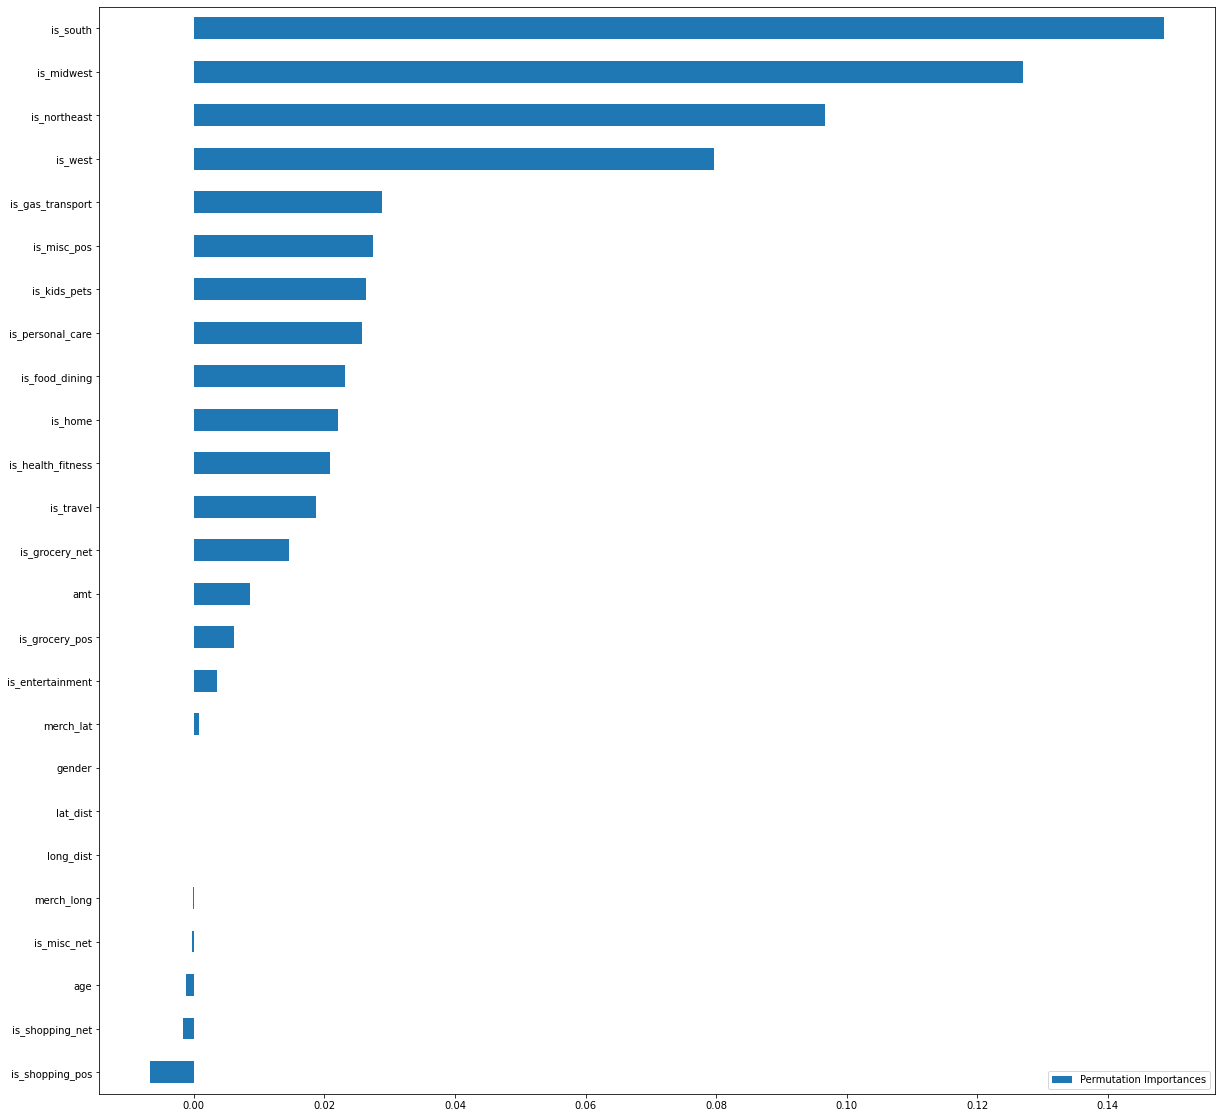

In [40]:
sorted_idx = perm.importances_mean.argsort()
values = pd.DataFrame(perm.importances_mean[sorted_idx], X_test.columns[sorted_idx], columns=['Permutation Importances'])
values.plot.barh(figsize=(20,20))

## What the Graph Says

The graph above shows that the **region** of the transaction, and **type of transaction** is **most important** in the given model, in comparison to the other features. This may be due to the fact that a good potion of features in the model are within these tow classes. Gender, Longitudinal Distance, and Latitudinal Distance haave virtually 0 impact on the model. 

## What insights Have been Gained?

The **location of the transaction and category of transaction compose the majority of data needed to track if a certain transaction is potentially fraudulent**. This makes intuitive sense, as if a transaction were located in a region further away from usual transactions, it would make sense to flag it as fraud.